<a href="https://colab.research.google.com/github/dineshRaja29/Frame-Level-Speech-Recognition/blob/main/EXPERIMENT_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color = 'green'>Frame-Level Speech Recognition

## <font color = 'green'>GOAL:
Given data which consists of melspectrograms, and phoneme labels for each 28-dimensional vector in the melspectrogram. The task is to predict the label of a particular 28-dimensional vector in an utterance (plus optional context) using a Feed Forward Deep Neural Network (FF-DNN or MLP).


## <font color = 'green'> OBJECTIVES:


* The main goal here is to explore neural networks for speech recognition, mainly focusing on phoneme state labelling.
* Speech recognition is an important field in deep learning with multiple applications. Speech is a fundamental form of human communication.
* Speech recognition involves converting spoken language into written text
or data that could be understood by machines.
* Speech data refers to audio recordings of human speech, while phonemes represent the smallest units of sound that can convey a different meaning(bake, take: b,t).
* Spectrograms are visual representations of the acoustic properties of speech signals, i.e. captures the changes in the frequency over time.

## <font color = 'green'> DATASET DETAILS

* Dataset contains audio recordings (utterances) and their phoneme state (subphoneme) labels.
* The data comes from articles published in the Wall Street Journal (WSJ) that are read aloud and labelled using the original text.
* The dataset provided has speech data in the form of Mel spectrograms.
* The data comprises of:
  * Speech recordings (raw mel spectrogram frames)
  * Frame-level phoneme state labels
* Training data have around 28539 samples



### <font color = 'green'> Phonemes and Phoneme States
* As letters are the atomic elements of written language, phonemes are the atomic elements of speech.
* It is crucial for us to have a means to distinguish different sounds in speech that may or may not represent the same letter or combinations of letters in the written alphabet.
* In the dataset, we will consider a total of 40 phonemes in this language.
* A powerful technique in speech recognition is to model speech as a markov process with unobserved states.
* This model considers observed speech to be dependent on unobserved state transitions. We refer to these unobserved states as phoneme states or subphonemes. For each phoneme, there are 3 respective phoneme
states. The transition graph of the phoneme states for a given phoneme is as follows:
* Example: [”+BREATH+”, ”+COUGH+”, ”+NOISE+”, ”+SMACK+”, ”+UH+”, ”+UM+”,  "AA”, ”AE”, ”AH”, ”AO”, ”AW”, ”AY”, ”B”, ”CH”, ”D”, ”DH”, ”EH”, ”ER”, ”EY”, ”F”, ”G”, ”HH”, ”IH”, ”IY”, ”JH”, ”K”, ”L”, ”M”, ”N”, ”NG”, ”OW”, ”OY”, ”P”, ”R”, ”S”, ”SH”, ”SIL”, ”T”, ”TH”, ”UH”, ”UW”, ”V”, ”W”, ”Y”, ”Z”, ”ZH”]

* Hidden Markov Models (HMMs) estimate the parameters of this unobserved markov process (transition and emission probabilities) that maximize the likelihood of the observed speech data.
* We will take model-free approach and classify mel spectrogram frames using a neural network that takes a frame (plus optional context) and outputs class probabilities for all 40 phoneme states.
The training data has the corresponding phonemes for this data and we need to train an MLP for predicting.
We will be building a multilayer perceptron(MLP) that can effectively recognize and
label the phoneme states in the training data. An MLP is a type of neural network that comprises multiple
layers of perceptrons, that help it capture the features and patterns of the data.



### <font color = 'green'>Speech Representation
* Raw speech signal (also known as the speech waveform) is stored simply as a sequence of numbers that
represent the amplitude of the sound wave at each time step. This signal is typically composed of sound
waves of several different frequencies overlaid on top of one another. For human speech, these frequencies
represent the frequencies at which the vocal tract vibrates when we speak and produce sound. Since this
signal is not very useful for speech recognition if used directly as a waveform, we convert it into a more useful
representation called a "melspectrogram" in the feature extraction stage.
* The variation with time of the frequencies present in a particular speech sample are very useful in determining the phoneme being spoken. In order to separate out all the individual frequencies present in the signal, we
perform a variant of the Fourier Transform, called the Short-Time Fourier Transform (STFT) on small,
overlapping segments (called frames, each of 25ms) of the waveform. A single vector is produced as the result
of this transform. Since we use a stride of 10ms between each frame, we end up with 100 vectors per second of
speech. Finally, we convert each vector into a 28-dimensional vector (for further readings https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html). For an utterance T seconds long, this leaves us with a matrix
of shape (100\*T, 28) known as the melspectrogram. Note that in the dataset provided to you, we have
already done all of this pre-processing and provided the final (\*, 28) shaped melspectrograms to you.
The data provided consists of these melspectrograms, and phoneme labels
for each 28-dimensional vector in the melspectrogram. The task is to predict
the label of a particular 28-dimensional vector in an utterance.

## <font color = 'green'> PERFORMANCE METRIC

* Accuracy
* Confusion Matrix
* Precision and Recall

## <font color = 'green'> EXPERIMENT

* Build FF-DNN only without any batchnorm or dropout
* Different right and left context are added so that capture more variability in the speaker utterances smoothing
* Sparse MLP is created using the loss function
    * Reference: https://ieeexplore.ieee.org/document/5734801
* No Augmentation
* No hyper-parameter tuning however used our past knowledge to set hyper-paramters
* Advanced weight initialization, Label smoothing in loss function, gradient clipping and scheduler are used.

In [ ]:
! ls /content/

In [ ]:
!pip install torch-summary --quiet

In [ ]:
import torch
import numpy as np
import sklearn
import gc
import zipfile
import pandas as pd
from tqdm.auto import tqdm
import os
import datetime
import torchsummary
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


In [ ]:
# # using colab for including google drive to save model checkpoints in a folder
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir -p /root/.kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73249 sha256=1eb2377ecf831e583211bb9cc870e94d7a73f6a16237e41c635875efa12c87cc
  Stored in directory: /root/.cache/pip/wheels/b5/23/bd/d33cbf399584fa44fa049711892d333954a50ed4b86948109e
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.2
    Uninstalling kaggle-1.7.4.2:
      Successfully uninstalled kaggle-1.7.4.2


In [ ]:
with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"dineshbuswala","key":"a67fefaecacb98180c9d56e1b00b37de"}')

!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# commands to download data from kaggle

!kaggle competitions download -c 11785-hw1p2-f23 --force
!mkdir -p '/content/data'

# !unzip -qo /content/11785-hw1p2-f23.zip -d '/content/data'

100%|██████████████████████████████████████▊| 3.97G/3.99G [00:24<00:00, 195MB/s]
100%|███████████████████████████████████████| 3.99G/3.99G [00:24<00:00, 173MB/s]


In [ ]:
!unzip -qo /kaggle/working/11785-hw1p2-f23.zip -d '/content/data'

In [ ]:
! rm -r /content/data/11-785-f23-hw1p2/test-clean
! rm -r /content/11785-hw1p2-f23.zip

In [ ]:
! ls /content/data/11-785-f23-hw1p2/train-clean-100/mfcc/ | wc -l

28539


In [ ]:
### configuration variables
EPOCHS                          = 4
BATCH_SIZE                      = 2048 * 2
LEFT_CONTEXT                    = 7
RIGHT_CONTEXT       	        = 7
INITIAL_LEARNING_RATE           = 1e-3
L2_PENALTY                      = 1e-5
STEP_SIZE                       = 2
GAMMA                           = 0.1
BASE_DIRECTORY                  = '/content/data/11-785-f23-hw1p2/'
TRAINING_DATA                   = BASE_DIRECTORY + 'train-clean-100'
EVALUATION_DATA                 = BASE_DIRECTORY + 'dev-clean'
PHONEMES                        = ['[SIL]',   'AA',    'AE',    'AH',    'AO',    'AW',    'AY',
                                    'B',     'CH',    'D',     'DH',    'EH',    'ER',    'EY',
                                    'F',     'G',     'HH',    'IH',    'IY',    'JH',    'K',
                                    'L',     'M',     'N',     'NG',    'OW',    'OY',    'P',
                                    'R',     'S',     'SH',    'T',     'TH',    'UH',    'UW',
                                    'V',     'W',     'Y',     'Z',     'ZH'] #,    '[SOS]', '[EOS]']
PHONEMES_TO_INDEX                = {phoneme: idx for idx, phoneme in enumerate(PHONEMES)}
NUMBER_OF_NEURONS                = [2048, 2048, 1024, 1024, 512, 256, 256]
MODEL_DIR                        = "/content"
CLIP_VALUE                       = 1.0
LABEL_SMOOTHING                  = 0.01

In [ ]:
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, root, phonemes = PHONEMES_TO_INDEX,
                 left_context = LEFT_CONTEXT,
                 right_context = RIGHT_CONTEXT):

        self.left_context = left_context
        self.right_context = right_context
        self.phonemes_mapping = phonemes

        self.mfcc_dir = os.path.join(root, 'mfcc')
        self.transcript_dir = os.path.join(root, 'transcript')

        # List and sort mfcc and transcript files
        mfcc_names = sorted(os.listdir(self.mfcc_dir))
        transcript_names = sorted(os.listdir(self.transcript_dir))

        # Sanity check
        assert len(mfcc_names) == len(transcript_names), "Mismatch in number of MFCC and transcript files"

        total_frames = 0

        for i in range(len(mfcc_names)):
            mfcc_path = os.path.join(self.mfcc_dir, mfcc_names[i])

            mfcc = np.load(mfcc_path,
                           allow_pickle = False,
                           mmap_mode='r')
            total_frames += mfcc.shape[0]
            del mfcc

        sample_mfcc = np.load(os.path.join(self.mfcc_dir, mfcc_names[0]), allow_pickle=False)
        self.mfcc_dim = sample_mfcc.shape[1]
        ### Right Padding is added here automatically
        self.mfccs = np.zeros((total_frames + right_context, self.mfcc_dim))
        self.transcripts = [None] * (total_frames + right_context)
        ### Release memory
        del sample_mfcc, total_frames
        gc.collect()

        index = 0
        for i in range(len(mfcc_names)):
            mfcc = np.load(os.path.join(self.mfcc_dir, mfcc_names[i]),
                           allow_pickle = False,
                           mmap_mode = 'r')

            mfcc = (mfcc - mfcc.mean(axis = 1, keepdims = True)) / (mfcc.std(axis = 1, keepdims = True) + 1e-5)

            transcript = np.load(os.path.join(self.transcript_dir, transcript_names[i]),
                                 allow_pickle = False,
                                 mmap_mode='r')[1:-1]

            self.mfccs[index: index + mfcc.shape[0]] = mfcc
            self.transcripts[index: index + len(transcript)] = transcript
            index += mfcc.shape[0]
            del mfcc, transcript

            if i % 1000 == 0:
                gc.collect() ### Release memory

        # Save original dataset length (before adding right padding)
        self.length = len(self.mfccs) - right_context

        # Map transcript phonemes to indices
        self.transcripts = [self.phonemes_mapping.get(p, -1) for p in self.transcripts]

        ### Release memory
        del mfcc_names, transcript_names
        gc.collect()

    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        if ind < self.left_context:  # index is less than left context
            # zeros need to prepend with it
            padding = []
            for _ in range(self.left_context - ind):
                padding.append(np.zeros((1, self.mfcc_dim)))

            for i in range(ind):
                padding.append(self.mfccs[i][None, :])

            # Include current and right context frames
            current = self.mfccs[ind][None, :]  # Ensure shape (1, 28)
            right_context = [self.mfccs[i][None, :] for i in range(ind + 1, ind + 1 + self.right_context)]
            frames = np.concatenate(padding + [current] + right_context, axis=0)

        else:  # when index is greater than or equal to left context
            left_context_frames = self.mfccs[ind - self.left_context: ind]
            current = self.mfccs[ind][None, :]  # Ensure shape (1, 28)
            right_context_frames = self.mfccs[ind + 1: ind + 1 + self.right_context]

            frames = np.concatenate([left_context_frames, current, right_context_frames], axis=0)

        frames = frames.flatten()  # Flatten to get 1D data
        frames = torch.FloatTensor(frames)  # Convert to tensor
        phonemes = torch.tensor(self.transcripts[ind], dtype=torch.long)  # Convert label to tensor

        return frames, phonemes


In [ ]:
# Create a dataset object using the AudioDataset class for the training data
train_data = AudioDataset(TRAINING_DATA)

# Create a dataset object using the AudioDataset class for the validation data
val_data = AudioDataset(EVALUATION_DATA)


In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    num_workers = 2,
    batch_size  = BATCH_SIZE,
    pin_memory  = True,
    shuffle     = True
)

val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    num_workers = 1,
    batch_size  = BATCH_SIZE,
    pin_memory  = True,
    shuffle     = False
)

print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Validation dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))

Train dataset samples = 36091157, batches = 8812
Validation dataset samples = 1928204, batches = 471


In [ ]:
# # Testing code to check if data loaders are working as expecting
# total_batches = len(train_loader)

# for i, (frames, phoneme) in enumerate(train_loader):
#     if i < 10 or i >= total_batches - 10:
#         print(f"Batch {i + 1}/{total_batches}")
#         print("Frames:", frames)
#         print("Phoneme:", phoneme)
#         print("-" * 50)


In [ ]:
class Network(torch.nn.Module):
    def __init__(self, input_size):
        super(Network, self).__init__()

        # Neurons in each layer: input -> hidden(s) -> output
        self.neurons = [input_size] + NUMBER_OF_NEURONS + [len(PHONEMES)]

        layers = []
        for in_features, out_features in zip(self.neurons[:-2], self.neurons[1:-1]):
            layers.append(torch.nn.Linear(in_features, out_features))
            layers.append(torch.nn.ReLU())

        # Final layer (no activation)
        layers.append(torch.nn.Linear(self.neurons[-2], self.neurons[-1]))

        # Combine all into a sequential model
        self.model = torch.nn.Sequential(*layers)

        # Apply weight initialization
        self._initialize_weights()

    def _initialize_weights(self):
        print('Initialization of weights using Kaiming')
        for m in self.model:
            if isinstance(m, torch.nn.Linear):
                # Kaiming initialization for weights
                torch.nn.init.kaiming_uniform_(m.weight, nonlinearity = 'relu')


    def forward(self, x):
        out = self.model(x)
        return out


In [ ]:
INPUT_SIZE = (LEFT_CONTEXT + RIGHT_CONTEXT + 1) * 28
model = Network(INPUT_SIZE).to(device)
# Pass the input size as a tuple, without the batch dimension
torchsummary.summary(model, (INPUT_SIZE,))

Initialization of weights using Kaiming
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]         862,208
              ReLU-2                 [-1, 2048]               0
            Linear-3                 [-1, 2048]       4,196,352
              ReLU-4                 [-1, 2048]               0
            Linear-5                 [-1, 1024]       2,098,176
              ReLU-6                 [-1, 1024]               0
            Linear-7                 [-1, 1024]       1,049,600
              ReLU-8                 [-1, 1024]               0
            Linear-9                  [-1, 512]         524,800
             ReLU-10                  [-1, 512]               0
           Linear-11                  [-1, 256]         131,328
             ReLU-12                  [-1, 256]               0
           Linear-13                  [-1, 256]          65,792

In [ ]:
class SparseLoss(torch.nn.Module):
    def __init__(self, model, lambda_l1=1e-4):
        super(SparseLoss, self).__init__()
        self.ce_criterion = torch.nn.CrossEntropyLoss(label_smoothing = LABEL_SMOOTHING)
        self.lambda_l1 = lambda_l1
        self.model = model

        # Collect indices of Linear layers, skipping first and last
        self.linear_layer_indices = [
            i for i, layer in enumerate(self.model.model[1:-1], 1)
            if isinstance(layer, torch.nn.Linear)
        ]

    def forward(self, logits, targets):
        ce_loss = self.ce_criterion(logits, targets)

        sparse_loss = 0.0
        for i in self.linear_layer_indices:
            weight = self.model.model[i].weight  # [out_features, in_features]

            # Neuron-wise aggregation: sum inputs per neuron
            neuron_weights = weight.sum(dim=1)  # [out_features]

            # sum(log(1 + (neuron)^2))
            sparse_loss += torch.log1p(neuron_weights.pow(2)).sum()  # log1p(x) = log(1 + x)

        total_loss = ce_loss + self.lambda_l1 * sparse_loss
        return total_loss


In [ ]:
# criterion = torch.nn.CrossEntropyLoss(label_smoothing = LABEL_SMOOTHING) # Defining Loss function.
# We use CE because the task is multi-class classification
criterion = SparseLoss(model, lambda_l1 = 1e-4)
optimizer = torch.optim.Adam(model.parameters(),
                             lr = INITIAL_LEARNING_RATE,
                             weight_decay = L2_PENALTY) #Defining Optimizer
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size = STEP_SIZE, gamma = GAMMA
)
# Refer - https://pytorch.org/docs/stable/notes/amp_examples.html

In [ ]:
torch.cuda.empty_cache()
gc.collect()

101

In [ ]:
def train(model, dataloader, optimizer, criterion):

    model.train()
    tloss, tacc = 0, 0 # Monitoring loss and accuracy
    batch_bar   = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    for i, (frames, phonemes) in enumerate(dataloader):

        ### Initialize Gradients
        optimizer.zero_grad()

        ### Move Data to Device (Ideally GPU)
        frames      = frames.to(device)
        phonemes    = phonemes.to(device)

        ### Forward Propagation
        logits  = model(frames)

        ### Loss Calculation
        loss    = criterion(logits, phonemes)

        ### Backward Propagation
        loss.backward()

        ### Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_VALUE)

        ### Gradient Descent
        optimizer.step()

        tloss   += loss.item()
        tacc    += torch.sum(torch.argmax(logits, dim= 1) == phonemes).item()/logits.shape[0]

        batch_bar.set_postfix(loss="{:.04f}".format(float(tloss / (i + 1))),
                              acc="{:.04f}%".format(float(tacc*100 / (i + 1))))
        batch_bar.update()

        ### Release memory
        del frames, phonemes, logits
        torch.cuda.empty_cache()

    batch_bar.close()
    tloss   /= len(train_loader)
    tacc    /= len(train_loader)

    return tloss, tacc

In [ ]:
def eval(model, dataloader):

    model.eval() # set model in evaluation mode
    vloss, vacc = 0, 0 # Monitoring loss and accuracy
    batch_bar   = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')

    for i, (frames, phonemes) in enumerate(dataloader):

        ### Move data to device (ideally GPU)
        frames      = frames.to(device)
        phonemes    = phonemes.to(device)

        # makes sure that there are no gradients computed as we are not training the model now
        with torch.inference_mode():
            ### Forward Propagation
            logits  = model(frames)
            ### Loss Calculation
            loss    = criterion(logits, phonemes)

        vloss   += loss.item()
        vacc    += torch.sum(torch.argmax(logits, dim= 1) == phonemes).item()/logits.shape[0]


        batch_bar.set_postfix(loss="{:.04f}".format(float(vloss / (i + 1))),
                              acc="{:.04f}%".format(float(vacc*100 / (i + 1))))
        batch_bar.update()

        ### Release memory
        del frames, phonemes, logits
        torch.cuda.empty_cache()

    batch_bar.close()
    vloss   /= len(val_loader)
    vacc    /= len(val_loader)

    return vloss, vacc

In [ ]:
best_model_path = os.path.join(MODEL_DIR, "best_model.pt")
best_acc = -np.inf
for epoch in range(EPOCHS):
    ### clean up memory before computation
    torch.cuda.empty_cache()
    gc.collect()

    print(f"\nEpoch {epoch + 1}/{EPOCHS}")

    curr_lr = float(optimizer.param_groups[0]['lr'])
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = eval(model, val_loader)

    print(f"\tTrain Acc: {train_acc*100:.2f}%\tTrain Loss: {train_loss:.4f}\tLR: {curr_lr:.7f}")
    print(f"\tVal   Acc: {val_acc*100:.2f}%\tVal   Loss: {val_loss:.4f}")

    # Save model at every epoch
    epoch_model_path = os.path.join(MODEL_DIR, f"model_at_epoch_{epoch + 1}.pt")
    torch.save(model.state_dict(), epoch_model_path)

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Updated Best Model at: {best_model_path}")

    ### take step in adjusting the learning rate
    scheduler.step()




Epoch 1/4


Train:   0%|          | 0/8812 [00:00<?, ?it/s]

Val:   0%|          | 0/471 [00:00<?, ?it/s]

	Train Acc: 70.53%	Train Loss: 1.0100	LR: 0.0010000
	Val   Acc: 70.38%	Val   Loss: 1.0031
Updated Best Model at: /content/best_model.pt

Epoch 2/4


Train:   0%|          | 0/8812 [00:00<?, ?it/s]

Val:   0%|          | 0/471 [00:00<?, ?it/s]

	Train Acc: 75.57%	Train Loss: 0.8290	LR: 0.0010000
	Val   Acc: 71.77%	Val   Loss: 0.9586
Updated Best Model at: /content/best_model.pt

Epoch 3/4


Train:   0%|          | 0/8812 [00:00<?, ?it/s]

Val:   0%|          | 0/471 [00:00<?, ?it/s]

	Train Acc: 79.85%	Train Loss: 0.6779	LR: 0.0001000
	Val   Acc: 74.03%	Val   Loss: 0.8763
Updated Best Model at: /content/best_model.pt

Epoch 4/4


Train:   0%|          | 0/8812 [00:00<?, ?it/s]

Val:   0%|          | 0/471 [00:00<?, ?it/s]

	Train Acc: 81.11%	Train Loss: 0.6383	LR: 0.0001000
	Val   Acc: 73.92%	Val   Loss: 0.8873


In [ ]:
gc.collect()

83

In [ ]:
# Load best model after training
model.load_state_dict(torch.load('/content/best_model.pt'))

<All keys matched successfully>

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
model.eval()  # Set model in evaluation mode
predicted = []
groundtruth = []

for frames, phonemes in val_loader:

    # Move data to device
    frames = frames.to(device)
    phonemes = phonemes.to(device)

    # Disable gradient calculation
    with torch.inference_mode():
        logits = model(frames)

    predict = torch.argmax(logits, dim = 1)

    # Detach and move to CPU for evaluation
    predicted.extend(predict.detach().cpu().tolist())
    groundtruth.extend(phonemes.detach().cpu().tolist())

    # Release memory
    del frames, phonemes, logits, predict
    torch.cuda.empty_cache()

# Print classification report
print(classification_report(
    groundtruth,
    predicted,
    target_names = PHONEMES  # Skipping SOS and EOS tokens
))


              precision    recall  f1-score   support

       [SIL]       0.93      0.95      0.94    319908
          AA       0.59      0.58      0.58     29688
          AE       0.64      0.66      0.65     49298
          AH       0.62      0.63      0.62    123734
          AO       0.65      0.64      0.65     29340
          AW       0.69      0.64      0.66     20274
          AY       0.77      0.83      0.80     49332
           B       0.68      0.67      0.68     23607
          CH       0.65      0.60      0.62     12644
           D       0.66      0.56      0.60     62763
          DH       0.69      0.68      0.68     37100
          EH       0.60      0.59      0.60     47112
          ER       0.67      0.71      0.69     54928
          EY       0.73      0.76      0.74     36184
           F       0.71      0.79      0.75     37562
           G       0.73      0.69      0.71     13541
          HH       0.73      0.70      0.71     34813
          IH       0.62    

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

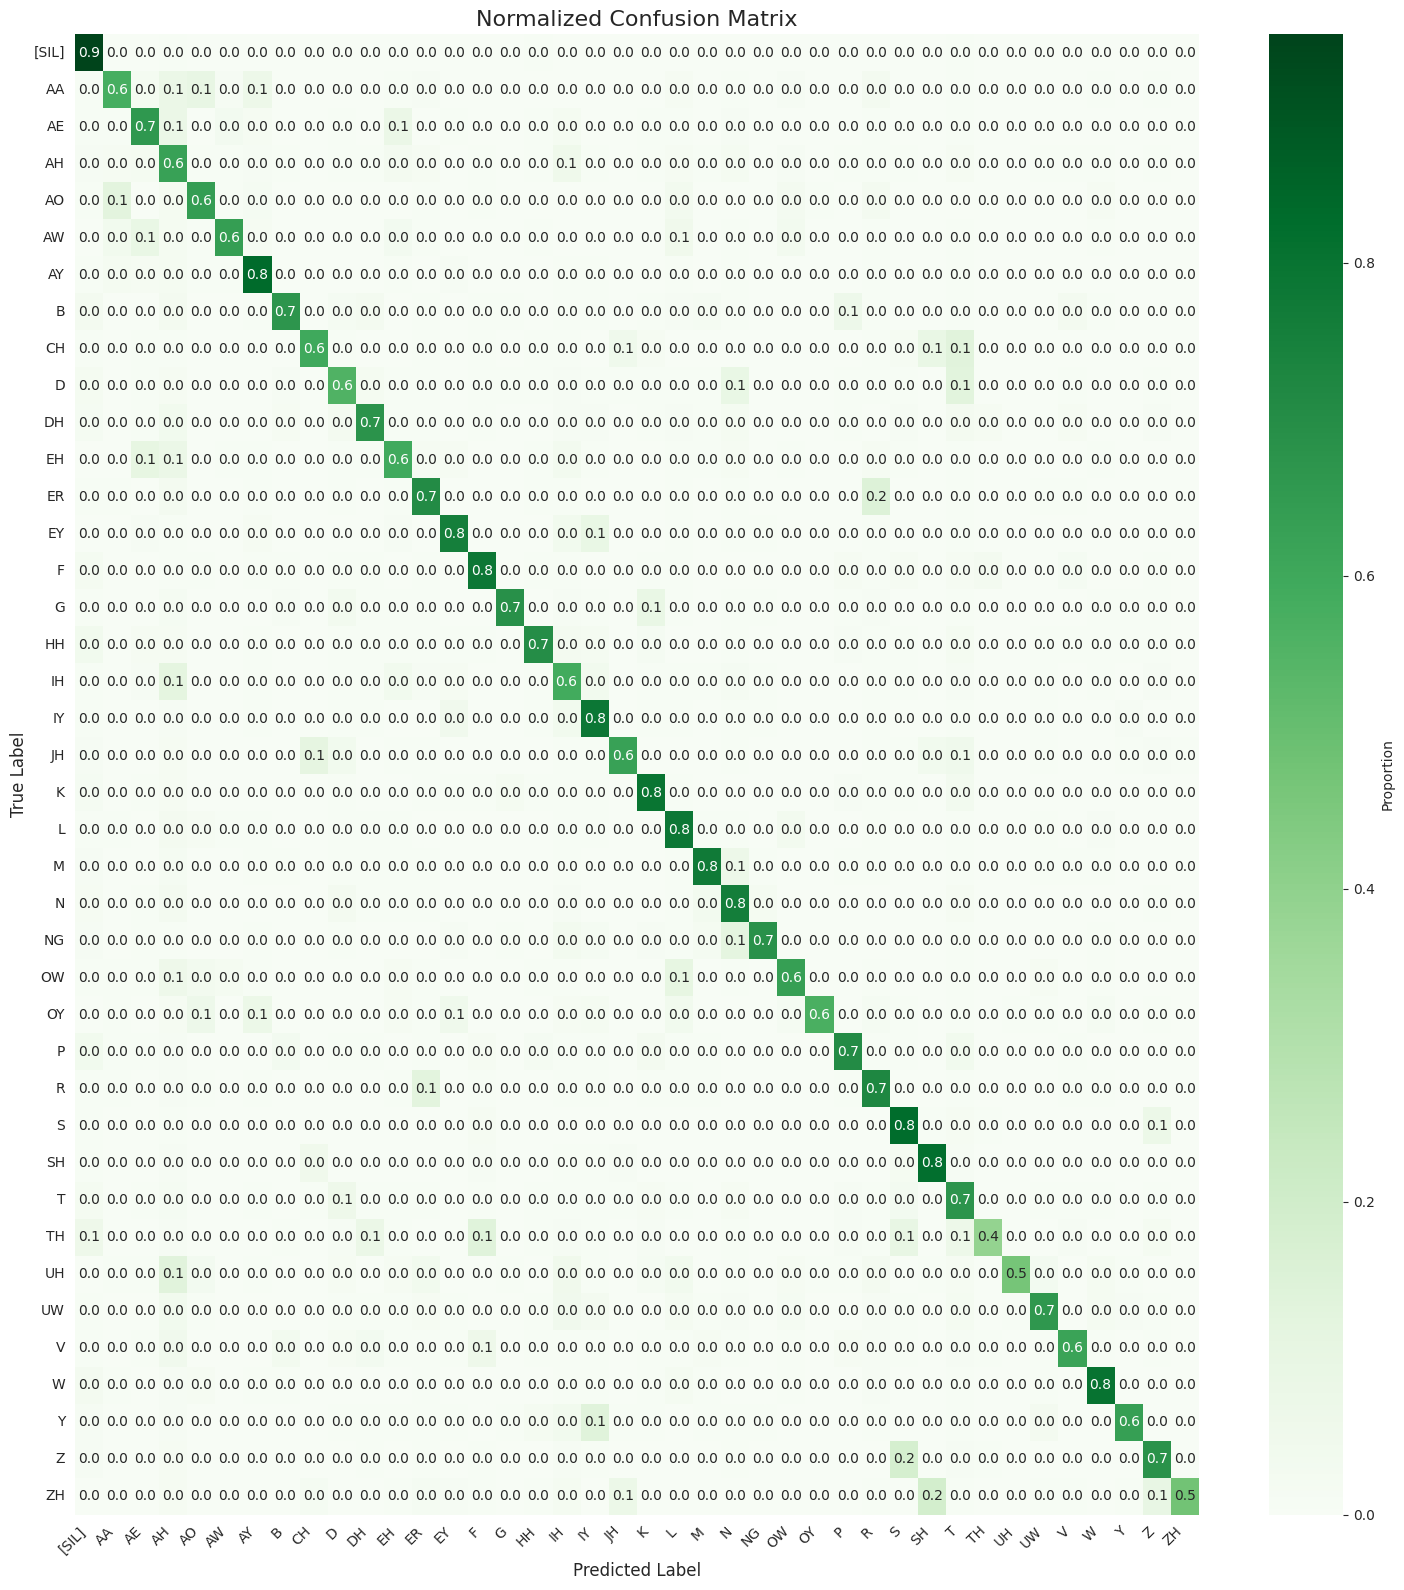

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(groundtruth, predicted)

# Normalize confusion matrix by row (i.e., by true labels)
cm_normalized = cm.astype('float') / cm.sum(axis = 1, keepdims = True)

# Replace NaNs (from division by zero, if any row sum is 0)
cm_normalized = np.nan_to_num(cm_normalized)

# Plot
plt.figure(figsize=(15, 16))
sns.heatmap(cm_normalized,
            annot=True,
            fmt=".1f",
            cmap="Greens",
            xticklabels=PHONEMES,
            yticklabels=PHONEMES,
            cbar_kws={'label': 'Proportion'})

plt.title('Normalized Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()
